In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
def hurst(ts, max_lag = 20): 
    ts = np.array(ts)
    lags = range(2, max_lag) 
    tau = [np.std(ts[lag:] - ts[:-lag]) for lag in lags] 
    poly = np.polyfit(np.log(lags), np.log(tau), 1) 
    return poly[0] * 2.0 # poly[0] = slope of the fit line....

In [3]:
def rolling_hurst(ts, window=170):
    hurst_vals = []
    for i in range(len(ts)):
        if i < window:
            hurst_vals.append(np.nan)
        else:
            window_data = ts[i-window:i]
            h = hurst(window_data)
            hurst_vals.append(h)
    return pd.Series(hurst_vals, index=ts.index)

In [4]:
def regime(h):
    if h > 0.55:
        return "trend"
    elif h < 0.45:
        return "revert"
    elif np.isnan(h):
        return np.nan
    else:
        return "random"

In [5]:
# Collect the data
data = yf.download("AAPL", start="2015-01-01",end="2026-01-01")
data.columns = data.columns.get_level_values(0)

data = data[['Close']] # collecting the closing prices
data.dropna(inplace=True) # removing all rows with null closing price in the original data
prices = np.log(data)

data["Rolling_Hurst"] = rolling_hurst(prices, window=170)
data["Regime"] = data["Rolling_Hurst"].apply(regime)

data['Regime'].value_counts()
data.dropna(inplace = True)

/tmp/ipykernel_24612/1049818525.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2015-01-01",end="2026-01-01")
[*********************100%***********************]  1 of 1 completed


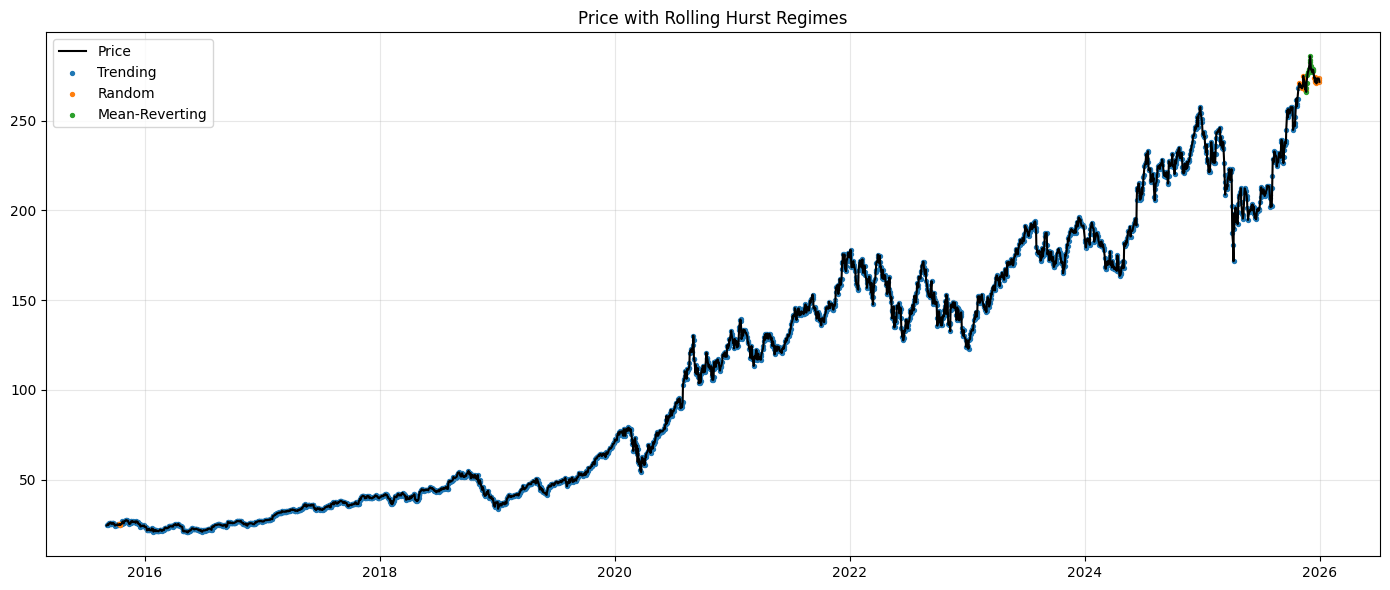

In [6]:
plt.figure(figsize=(14,6))


plt.plot(data.index, data["Close"], color="black", label="Price")


regimes = {
    "trend": ("Trending", "red"),
    "random": ("Random", "gray"),
    "revert": ("Mean-Reverting", "blue")
}

for key, (label, color) in regimes.items():
    subset = data[data["Regime"] == key]
    plt.scatter(
        subset.index,
        subset["Close"],
        s=8,
        label=label
    )

plt.title("Price with Rolling Hurst Regimes")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

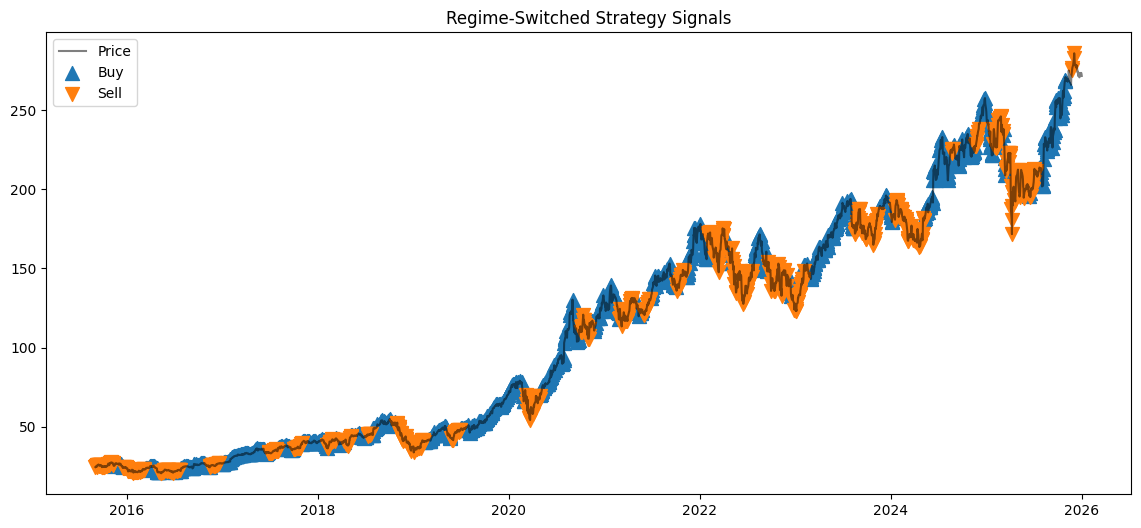

In [7]:
# Strategy 
if "Price" not in data.columns:
    data["Price"] = data["Close"]

# 1. Indicators
data['SMA_Fast'] = data['Price'].rolling(window=20).mean()
data['SMA_Slow'] = data['Price'].rolling(window=50).mean()

data['Rolling_Mean'] = data['Price'].rolling(window=20).mean()
data['Rolling_Std'] = data['Price'].rolling(window=20).std()
data['Z_Score'] = (data['Price'] - data['Rolling_Mean']) / data['Rolling_Std']

# 2. Signals
data['Signal'] = 0

hurst_trend_limit = 0.55
hurst_rev_limit = 0.40

for i in range(len(data)):

    h = data['Rolling_Hurst'].iloc[i]

    # skip NaNs
    if pd.isna(h):
        continue

    idx = data.index[i]

    # --- TRENDING ---
    if h > hurst_trend_limit:
        if data['SMA_Fast'].iloc[i] > data['SMA_Slow'].iloc[i]:
            data.loc[idx, 'Signal'] = 1
        else:
            data.loc[idx, 'Signal'] = -1

    # --- MEAN REVERT ---
    elif h < hurst_rev_limit:
        z = data['Z_Score'].iloc[i]

        if z < -2.0:
            data.loc[idx, 'Signal'] = 1
        elif z > 2.0:
            data.loc[idx, 'Signal'] = -1
            
    else:
        data.loc[idx, 'Signal'] = 0


# 3. Plot Signals
subset = data # can pick up a subset of the entire data to work on.

plt.figure(figsize=(14,6))
plt.plot(subset.index, subset['Price'], label='Price', color='black', alpha=0.5)

plt.scatter(
    subset[subset['Signal']==1].index,
    subset['Price'][subset['Signal']==1],
    marker='^',
    s=100,
    label='Buy'
)

plt.scatter(
    subset[subset['Signal']==-1].index,
    subset['Price'][subset['Signal']==-1],
    marker='v',
    s=100,
    label='Sell'
)

plt.title("Regime-Switched Strategy Signals")
plt.legend()
plt.show()

Total Return: -8.90%
Sharpe Ratio: 0.11


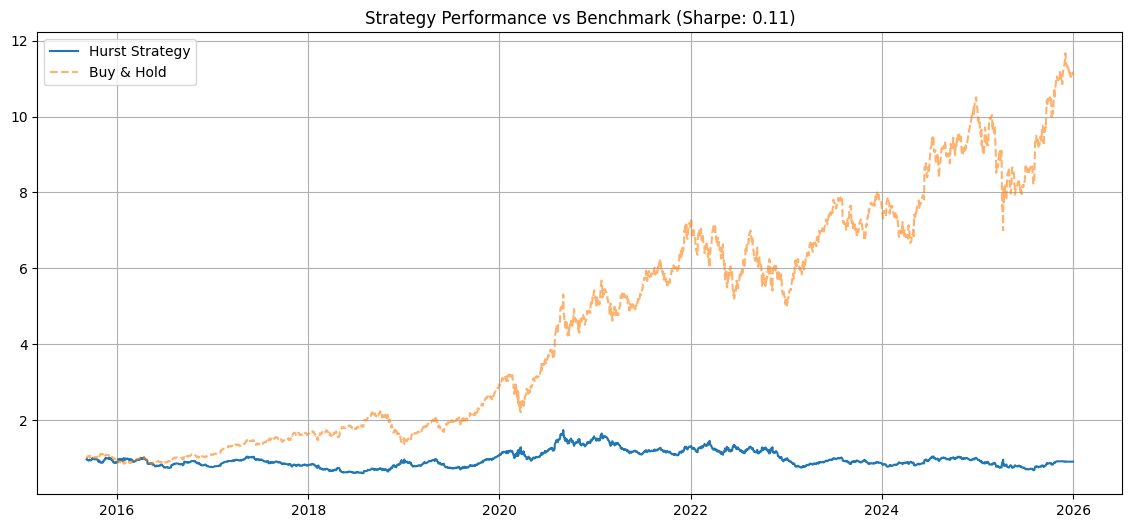

In [8]:
# Backtesting
data.columns
# 1. Market Returns
data['Market_Returns'] = data['Price'].pct_change()

# 2. Strategy Returns (avoid lookahead bias)
data['Strategy_Returns'] = data['Signal'].shift(1) * data['Market_Returns']

# 3. Drop NaNs created by rolling indicators + shifting
bt = data.dropna(subset=['Strategy_Returns']).copy()

# 4. Equity Curves
bt['Cumulative_Market'] = (1 + bt['Market_Returns']).cumprod()
bt['Cumulative_Strategy'] = (1 + bt['Strategy_Returns']).cumprod()

# 5. Performance Metrics
total_return = bt['Cumulative_Strategy'].iloc[-1] - 1
annualized_volatility = bt['Strategy_Returns'].std() * np.sqrt(252)

if bt['Strategy_Returns'].std() != 0:
    sharpe_ratio = (
        bt['Strategy_Returns'].mean() /
        bt['Strategy_Returns'].std()
    ) * np.sqrt(252)
else:
    sharpe_ratio = np.nan

print(f"Total Return: {total_return:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# 6. Plot
plt.figure(figsize=(14,6))
plt.plot(bt.index, bt['Cumulative_Strategy'], label='Hurst Strategy')
plt.plot(bt.index, bt['Cumulative_Market'], label='Buy & Hold', linestyle='--', alpha=0.6)

plt.title(f"Strategy Performance vs Benchmark (Sharpe: {sharpe_ratio:.2f})")
plt.legend()
plt.grid(True)
plt.show()

Running Stability Scan...


/tmp/ipykernel_24612/1428888666.py:52: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = (daily_ret.mean() / daily_ret.std()) * np.sqrt(252)


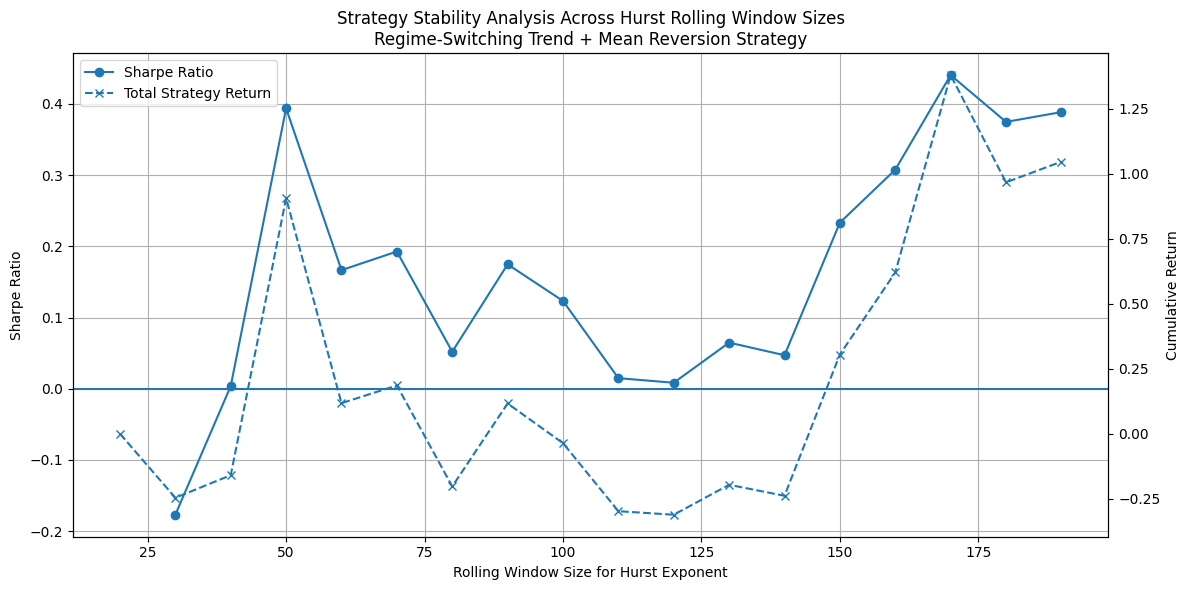

In [9]:
# --- Cell 7: Stability Scan ---

windows = range(20, 200, 10)
sharpe_scores = []
returns_scores = []

print("Running Stability Scan...")

price = data["Price"].copy()
market_ret = data["Market_Returns"].copy()

for w in windows:

    # 1. Hurst
    temp_hurst = price.rolling(window=w).apply(hurst, raw=True)

    # 2. Indicators
    fast_w = max(int(w/4), 2)
    slow_w = max(int(w/2), 3)

    sma_fast = price.rolling(fast_w).mean()
    sma_slow = price.rolling(slow_w).mean()

    roll_mean = price.rolling(fast_w).mean()
    roll_std  = price.rolling(fast_w).std()

    z_score = (price - roll_mean) / roll_std

    # 3. Signals
    sig_trend = np.where(sma_fast > sma_slow, 1, -1)
    sig_rev   = np.where(z_score < -2, 1,
                  np.where(z_score > 2, -1, 0))

    regime_trend = (temp_hurst > 0.55).astype(int)
    regime_rev   = (temp_hurst < 0.45).astype(int)

    final_sig = (regime_trend.values * sig_trend) + \
                (regime_rev.values   * sig_rev)

    final_sig = pd.Series(final_sig, index=data.index)

    # 4. Returns
    daily_ret = final_sig.shift(1) * market_ret

    daily_ret = daily_ret.replace([np.inf, -np.inf], np.nan).dropna()

    if len(daily_ret) < 50:
        sharpe_scores.append(np.nan)
        returns_scores.append(np.nan)
        continue

    sharpe = (daily_ret.mean() / daily_ret.std()) * np.sqrt(252)
    cum_ret = (1 + daily_ret).cumprod().iloc[-1] - 1

    sharpe_scores.append(sharpe)
    returns_scores.append(cum_ret)


# --- Plot ---
fig, ax1 = plt.subplots(figsize=(12,6))

# Sharpe Ratio Plot
line1 = ax1.plot(
    windows,
    sharpe_scores,
    marker="o",
    label="Sharpe Ratio"
)

ax1.set_xlabel("Rolling Window Size for Hurst Exponent")
ax1.set_ylabel("Sharpe Ratio")
ax1.axhline(0)
ax1.grid(True)

# Total Return Plot (Secondary Axis)
ax2 = ax1.twinx()

line2 = ax2.plot(
    windows,
    returns_scores,
    marker="x",
    linestyle="--",
    label="Total Strategy Return"
)

ax2.set_ylabel("Cumulative Return")

# Combined Legend
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="best")

# Title
plt.title(
    "Strategy Stability Analysis Across Hurst Rolling Window Sizes\n"
    "Regime-Switching Trend + Mean Reversion Strategy"
)

plt.tight_layout()
plt.show()



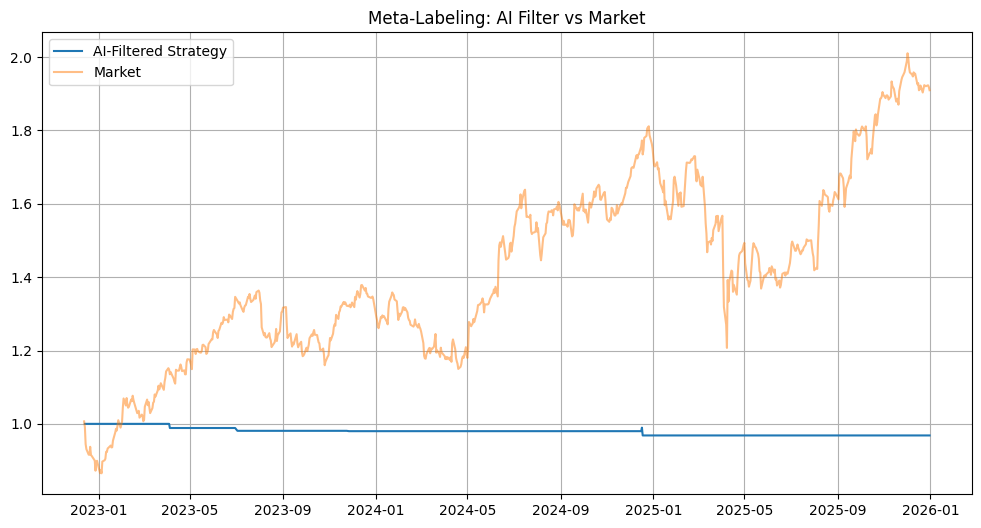

Original Sharpe: -0.025034734002247476
Meta Sharpe: -0.6688892305224929


In [10]:
# Meta labeling :
# --- Feature Engineering 
df_ml = data.copy()

# Volatility
df_ml['Vol_20'] = df_ml['Market_Returns'].rolling(20).std()

# RSI from PRICE
delta = df_ml['Price'].diff()
gain = delta.clip(lower=0).rolling(14).mean()
loss = -delta.clip(upper=0).rolling(14).mean()
rs = gain / loss
df_ml['RSI'] = 100 - (100/(1+rs))

# Target construction
df_ml['Trade_Result'] = (
    df_ml['Signal'] *
    df_ml['Market_Returns'].shift(-1)
) > 0

df_ml['Target'] = df_ml['Trade_Result'].astype(int)

# FINAL cleanup
df_ml.dropna(inplace=True)

# --- Train/Test Split ---
train_size = int(len(df_ml)*0.7)

features = ['Rolling_Hurst','Vol_20','RSI']

X = df_ml[features]
y = df_ml['Target']

X_train,X_test = X.iloc[:train_size],X.iloc[train_size:]
y_train,y_test = y.iloc[:train_size],y.iloc[train_size:]

clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=3,
    random_state=42
)
clf.fit(X_train,y_train)

# --- Meta Strategy ---
probs = clf.predict_proba(X_test)[:,1]

test_signals = df_ml['Signal'].iloc[train_size:]
ai_confidence = pd.Series(probs,index=test_signals.index)

mask = (ai_confidence>0.55)&(~ai_confidence.isna())
meta_signal = test_signals.where(mask,0)

meta_returns = (
    meta_signal.shift(1)*
    df_ml['Market_Returns'].iloc[train_size:]
)

cum_meta = (1+meta_returns).cumprod()

# --- Plot ---
plt.figure(figsize=(12,6))
plt.plot(cum_meta,label='AI-Filtered Strategy')
plt.plot(
    (1+df_ml['Market_Returns'].iloc[train_size:]).cumprod(),
    label='Market',alpha=0.5
)
plt.title("Meta-Labeling: AI Filter vs Market")
plt.legend()
plt.grid(True)
plt.show()

# --- Sharpe ---
def sharpe(x):
    if x.std()==0 or np.isnan(x.std()):
        return np.nan
    return (x.mean()/x.std())*np.sqrt(252)

original_sharpe = sharpe(
    df_ml['Strategy_Returns'].iloc[train_size:]
)
new_sharpe = sharpe(meta_returns)

print("Original Sharpe:",original_sharpe)
print("Meta Sharpe:",new_sharpe)
